In [1]:
import tensorflow as tf
import numpy as np

# fix the seeds in the parse file..
np.random.seed(0)
from fetch_data import qm9_parse, qm9_fetch

In [2]:
qm9_records = qm9_fetch()
data = qm9_parse(qm9_records)

Found existing record file, delete if you want to re-fetch


In [3]:
import jax.numpy as jnp
import jax.experimental.optimizers as optimizers
import jax
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [4]:
import seaborn as sns
import matplotlib as mpl

sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)

In [5]:
shuffled_data = data.shuffle(7000,reshuffle_each_iteration=False)
test_set = shuffled_data.take(10)
valid_set = shuffled_data.skip(10).take(10)
train_set = shuffled_data.skip(20).take(90)

In [6]:
def convert_record(d, task_num):
    # break up record
    (e, x), y = d
    e = e.numpy()
    x = x.numpy()
    r = x[:, :3]
    # make ohc size larger
    # so use same node feature
    # shape later
    ohc = np.zeros((len(e), 16))
    ohc[np.arange(len(e)), e - 1] = 1
    return (ohc, r), y.numpy()[task_num]

In [7]:
ys = [convert_record(d, 11)[1] for d in train_set]
train_ym = np.mean(ys)
train_ys = np.std(ys)
print("Mean = ", train_ym, "Std =", train_ys)

Mean =  -349.73703 Std = 41.795647


In [8]:
def transform_label(y,train_ym,train_ys):
    return (y - train_ym) / train_ys

def transform_prediction(y,train_ym,train_ys):
    return y * train_ys + train_ym

In [9]:
epochs = 10
eta = 1e-3

In [10]:
# convert coordinates to pairwise distances
def x2e(x,w_rbf):
    '''convert xyz coordinates to inverse pairwise distance'''
    d = jnp.array([(i+1)*20/32 for i in range(32)])
    r = jnp.sum((x - x[:, jnp.newaxis, :]), axis=-1)
    e = jnp.exp((-(r[...,jnp.newaxis]-d[jnp.newaxis,...][jnp.newaxis,...])**2)/w_rbf)
    return e


def gnn_layer(nodes, edges, features, we, web, wv, wu):
    """Implementation of the GNN"""
    # step 1 --> compute features stored per edge based on current edge feature and node feature

    ek = jax.nn.leaky_relu(
        jnp.repeat(nodes[jnp.newaxis,...], nodes.shape[0], axis=0) @ we * edges)

    # step 2 --> aggregate to node
    ebar = jnp.mean(ek, axis=1)

    # step 3 --> update node features
    v = jax.nn.leaky_relu(ebar @ wv) + nodes
    # step 4 --> update global feature
    global_node_features = jnp.sum(v, axis=0)
    u = jax.nn.leaky_relu(global_node_features  @ wu) + features
    return v, edges, u

In [11]:
graph_feature_len = 16
node_feature_len = 32
msg_feature_len = 32

# make our weights
def init_weights(g, n, m):
    np.random.seed(0)
    we = np.random.normal(size=(n, m), scale=1e-1)
    np.random.seed(0)
    wb = np.random.normal(size=(m), scale=1e-1)
    np.random.seed(0)
    wv = np.random.normal(size=(m, n), scale=1e-1)
    np.random.seed(0)
    wu = np.random.normal(size=(n, g), scale=1e-1)
    return [ we, wb, wv, wu]

In [12]:
# get weights for both layers

w1 = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
w2 = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
np.random.seed(0)
w3 = np.random.normal(size=(graph_feature_len))
b = 0.0
np.random.seed(0)
w_rbf = np.random.normal(size=(1), scale=1e-1)
np.random.seed(0)
matrix = np.random.normal(size=(16, node_feature_len), scale=1e-1)

@jax.jit
def model(nodes, coords, w1, w2, w3, b, w_rbf, matrix):
    f0 = jnp.zeros(graph_feature_len)
    e0 = x2e(coords,w_rbf)
    n0 = nodes@ matrix
    n1, e1, f1 = gnn_layer(n0, e0, f0, *w1)
    n2, e2, f2 = gnn_layer(n1, e1, f1, *w2)
    yhat = f2 @ w3 + b
    return yhat


def loss(nodes, coords, y, w1, w2, w3, b, w_rbf,matrix ):
    return (model(nodes, coords, w1, w2, w3, b,w_rbf,matrix) - y) ** 2


loss_grad = jax.grad(loss, (3, 4, 5, 6,7,8))

In [13]:
ys = [convert_record(d, 11)[1] for d in train_set]
train_ym = np.mean(ys)
train_ys = np.std(ys)
print("Mean = ", train_ym, "Std =", train_ys)

Mean =  -349.73703 Std = 41.795647


In [14]:
epochs = 1000

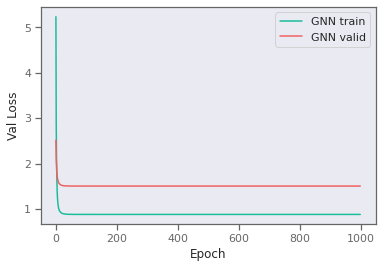

In [15]:
eta = 0.00001
train_loss = [0.0 for _ in range(epochs)]
val_loss = [0.0 for _ in range(epochs)]

for epoch in range(epochs):
    #train_loss = 0
    for d in train_set:
        (e, x), y_raw = convert_record(d, 11)
        y = transform_label(y_raw,train_ym,train_ys)
        e = e 
        b = np.mean(y)
        grad = loss_grad(e, x, y, w1, w2, w3, b,w_rbf,matrix)
        
        # update regression weights
        w3 -= eta * grad[2]
        b -= eta * grad[3]
        w_rbf -= eta * grad[4]
        matrix -= eta * grad[5]

        # update GNN weights
        for i, w in [(0, w1), (1, w2)]:
            for j in range(len(w)):
                w[j] -= eta * grad[i][j]/10
        train_loss[epoch] += loss(e, x, y, w1, w2, w3, b, w_rbf, matrix)
    train_loss[epoch] = jnp.sqrt(train_loss[epoch] / 10)
    #print('train_loss = ', train_loss[epoch])
        
    # compute validation loss
    for v in valid_set:
        (e, x), y_raw = convert_record(v,11)
        y = transform_label(y_raw,train_ym,train_ys)
        e = e 
        # convert SE to RMSE
        val_loss[epoch] += loss(e, x, y, w1, w2, w3, b, w_rbf, matrix)
    val_loss[epoch] = jnp.sqrt(val_loss[epoch] / 10)
    #print('valid_loss = ', val_loss[epoch])
    eta *= 0.9

plt.plot(train_loss, label="GNN train")
plt.plot(val_loss, label="GNN valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.show()

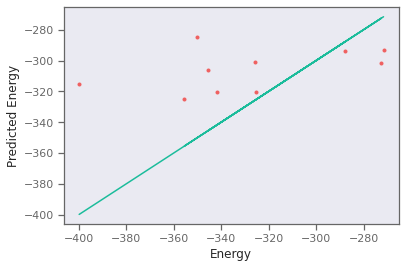

In [16]:
ys = []
yhats = []
for v in test_set:
    (e, x), y = convert_record(v, 11)
    e = e 
    ys.append(y)
    yhat_raw = model(e, x, w1, w2, w3, b,w_rbf,matrix)
    yhats.append(transform_prediction(yhat_raw,train_ym,train_ys))


plt.plot(ys, ys, "-")
plt.plot(ys, yhats, ".")
plt.xlabel("Energy")
plt.ylabel("Predicted Energy")
plt.show()